# Decision Tree

- 랜덤 포레스트의 기본 구성 요소

### 1. 결정 트리의 학습과 시각화

In [5]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris(as_frame=True)
X_iris = iris.data[['petal length (cm)', 'petal width (cm)']].values
y_iris = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X_iris, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=42)

In [14]:
# export_graphviz() 함수를 사용해 그래프 정의를 iris_tree.dot 파일로 출력하여
# 훈련된 결정 트리를 시각화 할 수 있음

import matplotlib.pyplot as plt
from pathlib import Path  # 파일 시스템 경로 cover

IMAGES_PATH = Path() / 'images' / 'decision_trees'
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = IMAGES_PATH / f'{fig_id}.{fig_extension}'
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


from sklearn.tree import export_graphviz

export_graphviz(
    tree_clf, 
    out_file=str(IMAGES_PATH / 'iris_tree.dot'),  # PATH
    feature_names=['petal length (cm)', 'petal width (cm)'], 
    class_names = iris.target_names, 
    rounded=True,  # 트리 노드의 모서리 둥글게
    filled=True  # 클래스별 노드의 색상을 지정하여 색칠
)

In [ ]:
from graphviz import Source

Source.from_file(IMAGES_PATH / 'iris_tree.dot')

### 2. 예측하기

- 결정 트리의 여러 장점 중 하나는 데이터 전처리가 거의 필요하지 않다는 것

- 사이킷런은 이진 트리만 만드는 CART 알고리즘을 사용

- 그러므로 리프 노드 외의 모든 노드는 자식 노드를 두 개씩 가짐

- ID3 같은 알고리즘은 둘 이상의 자식 노드를 가진 결정 트리를 만들 수 있음

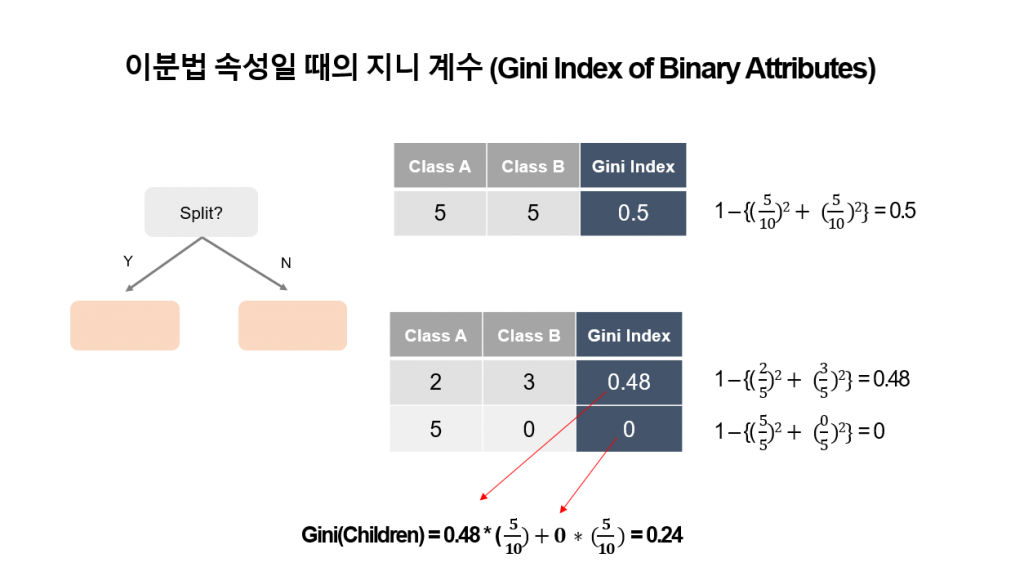

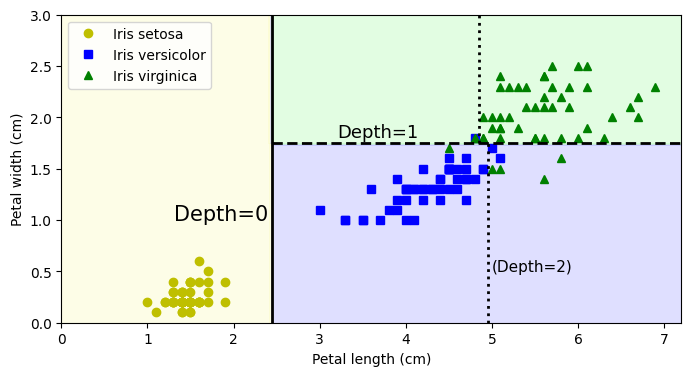

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

custom_cmap = ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])
plt.figure(figsize=(8, 4))

lengths, widths = np.meshgrid(np.linspace(0, 7.2, 100), np.linspace(0, 3, 100))
X_iris_all = np.c_[lengths.ravel(), widths.ravel()]
y_pred = tree_clf.predict(X_iris_all).reshape(lengths.shape)
plt.contourf(lengths, widths, y_pred, alpha=0.3, cmap=custom_cmap)
for idx, (name, style) in enumerate(zip(iris.target_names, ("yo", "bs", "g^"))):
    plt.plot(X_iris[:, 0][y_iris == idx], X_iris[:, 1][y_iris == idx],
             style, label=f"Iris {name}")

# extra code – this section beautifies and saves Figure 6–2
tree_clf_deeper = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf_deeper.fit(X_iris, y_iris)
th0, th1, th2a, th2b = tree_clf_deeper.tree_.threshold[[0, 2, 3, 6]]
plt.xlabel("Petal length (cm)")
plt.ylabel("Petal width (cm)")
plt.plot([th0, th0], [0, 3], "k-", linewidth=2)
plt.plot([th0, 7.2], [th1, th1], "k--", linewidth=2)
plt.plot([th2a, th2a], [0, th1], "k:", linewidth=2)
plt.plot([th2b, th2b], [th1, 3], "k:", linewidth=2)
plt.text(th0 - 0.05, 1.0, "Depth=0", horizontalalignment="right", fontsize=15)
plt.text(3.2, th1 + 0.02, "Depth=1", verticalalignment="bottom", fontsize=13)
plt.text(th2a + 0.05, 0.5, "(Depth=2)", fontsize=11)
plt.axis([0, 7.2, 0, 3])
plt.legend()

plt.show()

- Depth = 2

- Depth가 추가되면 결정 트리 추가 분할

- 결정 트리는 직관적이고 결정 방식 이해가 쉬움

    - 화이트박스 모델

- 랜덤 포레스트나 신경망은 예측을 쉽게 설명하지 못함

    - 블랙박스 모델



### 3. 클래스 확률 추정

In [7]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [8]:
tree_clf.predict([[5, 1.5]])

array([1])

### 4. CART 훈련 알고리즘

- 사이킷런은 결정 트리를 훈련시키기 위해 CART 알고리즘 사용

    - CART는 그리디 알고리즘

    - 최적의 솔루션을 항상 보장하지는 못 함

    - 최적의 트리는 NP-완전 문제

    - NP-완전 문제는 O(exp(m)) 시간이 필요하고, 매우 작은 훈련 세트 적용 어려움

- 훈련 세트를 하나의 특성 k의 임곗값 t_k를 사용해 두 개의 서브셋으로 나눔

- k와 t_k를 고르는 방법

- 크기에 따른 가중치가 적용된 가장 순수한 서브셋으로 나눌 수 있는 (k, t_k) 짝을 찾음

- 이 알고리즘이 최소화해야 하는 비용 함수

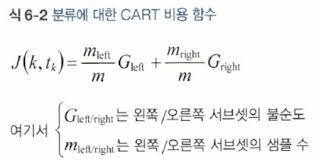

- CART 알고리즘이 훈련 세트를 성공적으로 둘로 나누었다면 이를 반복하여 서브셋 분할

- 이 과정은 max_depth 최대 깊이가 되면 중지하거나

- 불순도를 줄이는 분할을 찾을 수 없을 때 멈춤

- 다른 몇 개의 매개변수도 중지 조건에 관여

    - min_samples_split, min_samples_leaf, min_weight_fraction_leaf, max_leaf_nodes

### 5. 계산 복잡도

- 일반적으로 결정 트리는 거의 균형을 이루고 있으므로 결정 트리 탐색을 위해서는

- O(log<sub>2</sub>(m))개의 노드를 거쳐야 함

- 각 노드는 하나의 특성값만 확인하기 때문에 예측에 필요한 전체 복잡도는 특성 수와 무관

- 그래서 큰 훈련 세트를 다룰 때도 에측 속도가 매우 빠름

- 각 노드에서 모든 샘플의 모든 특성을 비교하면 훈련 복잡도는 O(n * mlog<sub>2</sub>(m))


### 6. 지니 불순도 엔트로피

- 기본적으로는 지니 불순도를 사용하지만 엔트로피 불순도도 사용 가능

- 두 가지 불순도의 큰 차이는 없음

- 지니 불순도는 빈도 높은 클래스를 한쪽 가지로 고립시키는 경향이 있음

- 반면 렌트로피는 조금 더 균형잡힌 트리를 만듦

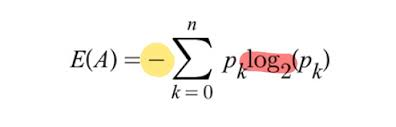

### 7. 규제 매개변수

- 결정 트리는 훈련 데이터에 대한 제약 사항이 거의 없음

- 제한을 두지 않으면 트리가 훈련 데이터에 아주 가깝게 맞추려고 해서 과대적합이 쉽게 일어남

- 결정 트리는 모델 파라미터가 없는 것이 아닌 훈련되기 전에 파라미터수가 결정되지 않음

- 이런 모델을 비파라미터 모델이라고 부름

- 사이킷런에서는 max_depth매개변수로 이를 조절

- max_depth를 줄이면 모델을 규제하게 되고 과대적합의 위험이 감소

- DecisionTreeClassifier에는 비슷하게 결정 트리의 형태를 제한하는 매개변수 존재

    - min_samples_split: 분할되기 위해 노드가 가져야 하는 최소 샘플 수

    - min_samples_leaf: 리프 노드가 가지고 있어야 할 최소 샘플 수

    - min_weight_fraction_leaf: min_samples_leaf와 같지만 가중치가 부여된 전체 샘플 수에서의 비율

    - max_leaf_nodes: 리프 노드의 최대 수

    - max_features: 각 노드에서 분할에 사용할 특성의 최대 수

- min_으로 시작하는 매겨변수를 증가시키거나

- max_로 시작하는 매개변수를 감소시키면 모델 규제가 커짐

In [9]:
from sklearn.datasets import make_moons

X_moons, y_moons = make_moons(n_samples=150, noise=0.2, random_state=42)

tree_clf1 = DecisionTreeClassifier(random_state=42)
tree_clf2 = DecisionTreeClassifier(min_samples_leaf=5, random_state=42)

tree_clf1.fit(X_moons, y_moons)
tree_clf2.fit(X_moons, y_moons)

DecisionTreeClassifier(min_samples_leaf=5, random_state=42)

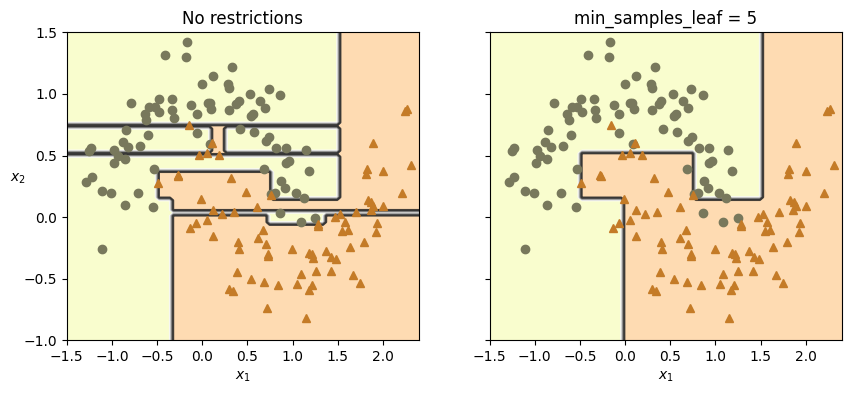

In [10]:
def plot_decision_boundary(clf, X, y, axes, cmap):
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=cmap)
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8)
    colors = {"Wistia": ["#78785c", "#c47b27"], "Pastel1": ["red", "blue"]}
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[cmap][idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf1, X_moons, y_moons,
                       axes=[-1.5, 2.4, -1, 1.5], cmap="Wistia")
plt.title("No restrictions")
plt.sca(axes[1])
plot_decision_boundary(tree_clf2, X_moons, y_moons,
                       axes=[-1.5, 2.4, -1, 1.5], cmap="Wistia")
plt.title(f"min_samples_leaf = {tree_clf2.min_samples_leaf}")
plt.ylabel("")
plt.show()

- 제한 없이 결정 트리를 훈련시키고 불필요한 노드를 가지치기(pruning)하는 알고리즘도 존재

- 순도를 높이는 것이 통계적으로 큰 효과가 없다면 리프 노드 바로 위의 노드는 불필요할 수 있음

- 대표적으로 chi-squared test를 사용하여 우연히 향상된 것인지 추정

- p-value가 어떤 임곗값(통상적으로 5%)보다 높으면 그 노드는 불필요한 것으로 간주되고 자식 노드는 삭제

### 8. 회귀

In [18]:
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X_quad = np.random.rand(200, 1) - 0.5
y_quad = X_quad ** 2 + 0.025 * np.random.randn(200, 1)

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X_quad, y_quad)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [ ]:
export_graphviz(
    tree_reg,
    out_file=str(IMAGES_PATH / "regression_tree.dot"),
    feature_names=["x1"],
    rounded=True,
    filled=True
)
Source.from_file(IMAGES_PATH / "regression_tree.dot")

- 값을 예측

- 리프 노드에 있는 100개 훈련 샘플의 평균 타깃값이 예측값

In [19]:
tree_reg2 = DecisionTreeRegressor(max_depth=3, random_state=42)
tree_reg2.fit(X_quad, y_quad)

DecisionTreeRegressor(max_depth=3, random_state=42)

In [20]:
tree_reg.tree_.threshold

array([-0.30265072, -0.40830374, -2.        , -2.        ,  0.27175756,
       -2.        , -2.        ])

In [21]:
tree_reg2.tree_.threshold

array([-0.30265072, -0.40830374, -0.45416115, -2.        , -2.        ,
       -0.37022041, -2.        , -2.        ,  0.27175756, -0.21270403,
       -2.        , -2.        ,  0.40399227, -2.        , -2.        ])

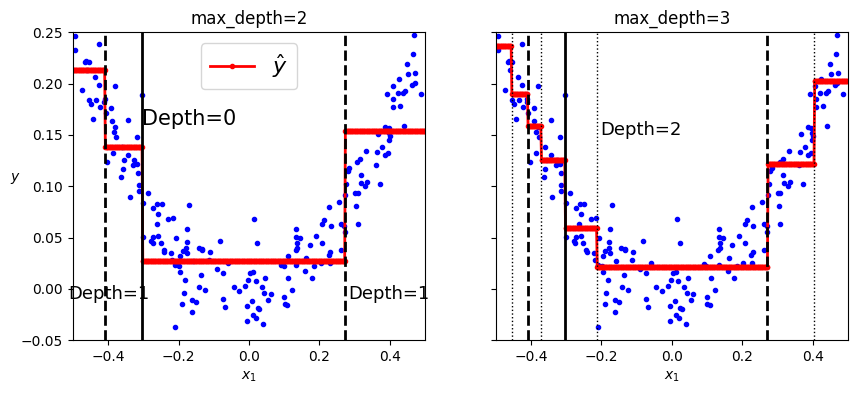

In [22]:
def plot_regression_predictions(tree_reg, X, y, axes=[-0.5, 0.5, -0.05, 0.25]):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$")
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_regression_predictions(tree_reg, X_quad, y_quad)

th0, th1a, th1b = tree_reg.tree_.threshold[[0, 1, 4]]
for split, style in ((th0, "k-"), (th1a, "k--"), (th1b, "k--")):
    plt.plot([split, split], [-0.05, 0.25], style, linewidth=2)
plt.text(th0, 0.16, "Depth=0", fontsize=15)
plt.text(th1a + 0.01, -0.01, "Depth=1", horizontalalignment="center", fontsize=13)
plt.text(th1b + 0.01, -0.01, "Depth=1", fontsize=13)
plt.ylabel("$y$", rotation=0)
plt.legend(loc="upper center", fontsize=16)
plt.title("max_depth=2")

plt.sca(axes[1])
th2s = tree_reg2.tree_.threshold[[2, 5, 9, 12]]
plot_regression_predictions(tree_reg2, X_quad, y_quad)
for split, style in ((th0, "k-"), (th1a, "k--"), (th1b, "k--")):
    plt.plot([split, split], [-0.05, 0.25], style, linewidth=2)
for split in th2s:
    plt.plot([split, split], [-0.05, 0.25], "k:", linewidth=1)
plt.text(th2s[2] + 0.01, 0.15, "Depth=2", fontsize=13)
plt.title("max_depth=3")

plt.show()

- CART 알고리즘은 불순도를 최소화하는 방향으로 분할하는 대신

- 평균제곱오차(MSE)를 최소화하도록 분할

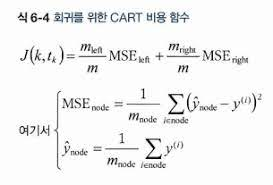

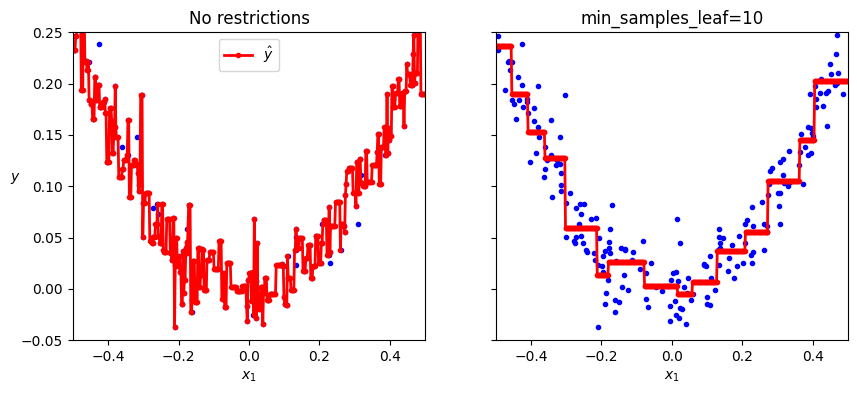

In [23]:
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X_quad, y_quad)
tree_reg2.fit(X_quad, y_quad)

x1 = np.linspace(-0.5, 0.5, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plt.plot(X_quad, y_quad, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([-0.5, 0.5, -0.05, 0.25])
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.legend(loc="upper center")
plt.title("No restrictions")

plt.sca(axes[1])
plt.plot(X_quad, y_quad, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([-0.5, 0.5, -0.05, 0.25])
plt.xlabel("$x_1$")
plt.title(f"min_samples_leaf={tree_reg2.min_samples_leaf}")

plt.show()

- 규제가 없다면 과대적합되기 쉽기 때문에 규제 적용

### 9. 불안정성

- 여러 장점에도 불구하고 결정 트리는 계단 모양의 결정 경계를 만듦

- 그래서 훈련 세트의 회전에 민감함

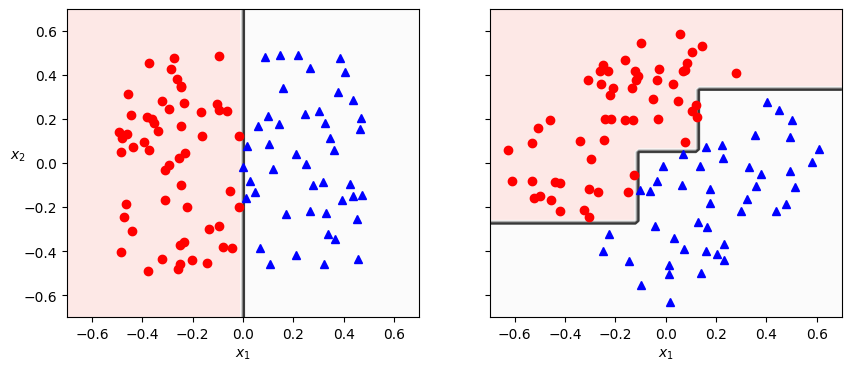

In [25]:
np.random.seed(6)
X_square = np.random.rand(100, 2) - 0.5
y_square = (X_square[:, 0] > 0).astype(np.int64)

angle = np.pi / 4  # 45 degrees
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                            [np.sin(angle), np.cos(angle)]])
X_rotated_square = X_square.dot(rotation_matrix)

tree_clf_square = DecisionTreeClassifier(random_state=42)
tree_clf_square.fit(X_square, y_square)
tree_clf_rotated_square = DecisionTreeClassifier(random_state=42)
tree_clf_rotated_square.fit(X_rotated_square, y_square)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf_square, X_square, y_square,
                       axes=[-0.7, 0.7, -0.7, 0.7], cmap="Pastel1")
plt.sca(axes[1])
plot_decision_boundary(tree_clf_rotated_square, X_rotated_square, y_square,
                       axes=[-0.7, 0.7, -0.7, 0.7], cmap="Pastel1")
plt.ylabel("")

plt.show()

- 주된 문제는 훈련 데이터에 있는 작은 변화에도 매우 민감하다는 것

- 사이킷런에서 사용하는 훈련 알고리즘은 확률적이기 때문에

- random_state 매개변수를 지정하지 않으면 같은 훈련 데이터에서도 다른 모델을 얻게 됨

In [28]:
tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, 
                                          random_state=40)  # random_state 변경
tree_clf_tweaked.fit(X_iris, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=40)

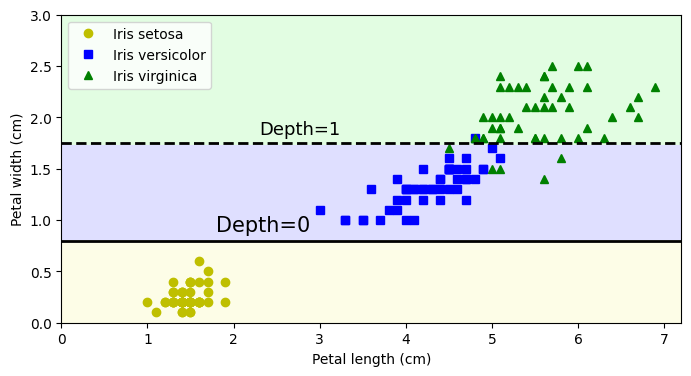

In [29]:
plt.figure(figsize=(8, 4))
y_pred = tree_clf_tweaked.predict(X_iris_all).reshape(lengths.shape)
plt.contourf(lengths, widths, y_pred, alpha=0.3, cmap=custom_cmap)

for idx, (name, style) in enumerate(zip(iris.target_names, ("yo", "bs", "g^"))):
    plt.plot(X_iris[:, 0][y_iris == idx], X_iris[:, 1][y_iris == idx],
             style, label=f"Iris {name}")

th0, th1 = tree_clf_tweaked.tree_.threshold[[0, 2]]
plt.plot([0, 7.2], [th0, th0], "k-", linewidth=2)
plt.plot([0, 7.2], [th1, th1], "k--", linewidth=2)
plt.text(1.8, th0 + 0.05, "Depth=0", verticalalignment="bottom", fontsize=15)
plt.text(2.3, th1 + 0.05, "Depth=1", verticalalignment="bottom", fontsize=13)
plt.xlabel("Petal length (cm)")
plt.ylabel("Petal width (cm)")
plt.axis([0, 7.2, 0, 3])
plt.legend()

plt.show()